# Understanding NuScenes dataset and creating functions
Import packages

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

Load nuscnenes mini dataset

In [2]:
nusc = NuScenes(version='v1.0-trainval', dataroot='data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 138.092 seconds.
Reverse indexing ...
Done reverse indexing in 7.6 seconds.


Look at what each scene contains based on description etc. Below, the city/area is significant to us as well as the roadway type/description.

In [94]:
nusc.list_scenes()

scene-0161, Car overtaking, parking lot, peds, ped ... [18-05-21 15:07:23]   19s, boston-seaport, #anns:1970
scene-0162, Leaving parking lot, parked cars, hidde... [18-05-21 15:07:43]   19s, boston-seaport, #anns:2230
scene-0163, Drive along street with dozens of parke... [18-05-21 15:08:03]   19s, boston-seaport, #anns:1585
scene-0164, Turn into narrow street, parked cars, p... [18-05-21 15:08:38]   19s, boston-seaport, #anns:745
scene-0165, Pass crane, truck and construction work... [18-05-21 15:09:15]   19s, boston-seaport, #anns:1423
scene-0166, Leaving narrow street, many cars [18-05-21 15:09:35]   19s, boston-seaport, #anns:1313
scene-0167, Pass parked trucks, sitting pedestrians... [18-05-21 15:10:13]   19s, boston-seaport, #anns:1455
scene-0168, Parking lot, peds, parked cars, parked ... [18-05-21 15:10:52]   19s, boston-seaport, #anns:1751
scene-0170, Turn left, truck parked in the middle o... [18-05-21 15:13:37]   19s, boston-seaport, #anns:1430
scene-0171, Densely parked tru

Below, we can see how many samples we have of each type of scenario/scene. This gives us a greater insight into what the dataset contains. The cell underneath then allows us to see the different information we can find within the dataset and allows us to explore NuScenes a bit more.

In [95]:
# Sample type and number of that sample
for i in range(len(nusc.scene)):
    my_scene = nusc.scene[i]
    description = my_scene['description']
    nbr_samples = my_scene['nbr_samples']
    print(description, ":", nbr_samples, "samples")

Construction, maneuver between several trucks : 40 samples
Intersection, peds, waiting vehicle, parked motorcycle at parking lot : 40 samples
Parking lot, barrier, exit parking lot : 40 samples
Random scene, arrive at intersection, cross intersection, jaywalkers : 40 samples
Overtaken by taxi, construction site : 39 samples
Sitting construction worker, parked bicycle, ped walking along road, construction vehicle, worker sitting on back of van : 40 samples
Van overtaking us, peds, jaywalker, bicycle rack, turn left : 39 samples
Several moving pedestrians, parked cards and motorcycle : 40 samples
Peds crossing, parked cars, garbage, peds waiting : 40 samples
Parked motorcycle, person pickung up garbage, pass construction vehicles and entrance to construction site : 40 samples
Turn left, pass trucks on both sides, construction workers, sleeping construction workers, garbage, parked cars : 40 samples
Nature, bus stop, parked cars, bus exits from the intersection : 40 samples
Follow bus, pa

In [104]:
# A sample example with its data
# my_scene0 = nusc2.scene[0]
# my_scene0
# first_sample_token = my_scene0['first_sample_token']
# first_sample_token 
# # The rendering command below is commented out because it tends to crash in notebooks
# nusc.render_sample(first_sample_token)
# my_sample = nusc.get('sample', first_sample_token)

Here, we look at different timestamps and see how the annotations around the car changes. This is important as external factors create a huge difference in safe driving. Not sure yet if this is relevent to the study.

In [7]:
def timestamp_change(my_instance):

    first_token = my_instance['first_annotation_token']
    last_token = my_instance['last_annotation_token']
    nbr_samples = my_instance['nbr_annotations']
    current_token = first_token

    i = 0
    found_change = False
    while current_token != last_token:
        current_ann = nusc.get('sample_annotation', current_token)
        current_attr = nusc.get('attribute', current_ann['attribute_tokens'][0])['name']

        if i == 0:
            pass
        elif current_attr != last_attr:
            print("Changed from `{}` to `{}` at timestamp {} out of {} annotated timestamps".format(last_attr, current_attr, i, nbr_samples))
            found_change = True

        next_token = current_ann['next']
        current_token = next_token
        last_attr = current_attr
        i += 1
        
my_instance = nusc.instance[27]
timestamp_change(my_instance)

Here we can calculate the visibility in the scene which is important when it comes to crashes and we can relate it to the factors we found from the crash data.

In [8]:
my_instance = nusc.instance[27]

def visibility(my_instance):
    first_token = my_instance['first_annotation_token']
    last_token = my_instance['last_annotation_token']
    nbr_samples = my_instance['nbr_annotations']
    current_token = first_token

    i = 0
    while current_token != last_token:

        visibility_token = nusc.get('sample_annotation', current_token)['visibility_token']
        current_ann = nusc.get('sample_annotation', current_token)

        print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
        # nusc.render_annotation(current_token)

        next_token = current_ann['next']
        current_token = next_token
        i += 1
        
# my_instance = nusc.instance[27]
# visibility(my_instance)

Not sure if I need this:

In [9]:
# get calibrated sensor translation
def cal_sensor_translation(cal_sens):
    cal_sensor_token = nusc.get('calibrated_sensor', cal_sens)
    cal_sensor_translation = cal_sensor_token['translation']
    cal_sensor_translation = np.array(cal_sensor_translation)
    return cal_sensor_translation

# get ego pose sensor translation
def ego_pose_translation(ego_sens):
    ego_pose = nusc.get('ego_pose', ego_sens)
    ego_pose_translation = ego_pose['translation']
    ego_pose_translation = np.array(ego_pose_translation)
    return ego_pose_translation

Finding euclidean distance

In [10]:
def euclidean_distance(point1, point2):
    
    return math.dist(point1, point2)

Here we find the distance between a car and an annotation. This allows to check for safe distances for not only cars around but also surrounding inanimate objects and people. 

In [11]:
def distance(sample_token):

    my_sample = nusc.get('sample', sample_token)
    anns = my_sample['anns']
    distances = []
    for i in range(len(anns)):
        ann = anns[i]
        ann_metadata =  nusc.get('sample_annotation', ann)
        sensor = 'LIDAR_TOP'

        #nusc.render_instance(ann_metadata['instance_token'])
        sensor_data = nusc.get('sample_data', my_sample['data'][sensor])

        ego_sens = sensor_data['ego_pose_token']                # ego pose sensor
        ego_pose_trans = ego_pose_translation(ego_sens)         # get ego pose sensor translation
        ann_translation = np.array(ann_metadata['translation']) # annotation translation
        
        # calcuating distances
        distance_ego_pose = euclidean_distance(ann_translation, ego_pose_trans)
        distances.append(distance_ego_pose)
    
        #print("ego pose distance:", distance_ego_pose)
    return distances-4.087

Lateral Distance

In [12]:
def lateral_distance(sample_token):

    my_sample = nusc.get('sample', sample_token)
    anns = my_sample['anns']
    distances = []
    for i in range(len(anns)):
        ann = anns[i]
        ann_metadata =  nusc.get('sample_annotation', ann)
        sensor = 'LIDAR_TOP'

        #nusc.render_instance(ann_metadata['instance_token'])
        sensor_data = nusc.get('sample_data', my_sample['data'][sensor])

        ego_sens = sensor_data['ego_pose_token']                # ego pose sensor
        ego_pose_trans = ego_pose_translation(ego_sens)         # get ego pose sensor translation
        ann_translation = np.array(ann_metadata['translation']) # annotation translation
        
        # calcuating distances
        distance_ego_pose = ego_pose_trans - ann_translation
        distance_ego_pose = distance_ego_pose[0]
        distances.append(distance_ego_pose)

        #print("ego pose distance:", distance_ego_pose)
    return distances

Longtudinal Distance

In [13]:
def longtudinal_distance(sample_token):

    my_sample = nusc.get('sample', sample_token)
    anns = my_sample['anns']
    distances = []
    for i in range(len(anns)):
        ann = anns[i]
        ann_metadata =  nusc.get('sample_annotation', ann)
        sensor = 'LIDAR_TOP'

        #nusc.render_instance(ann_metadata['instance_token'])
        sensor_data = nusc.get('sample_data', my_sample['data'][sensor])

        ego_sens = sensor_data['ego_pose_token']                # ego pose sensor
        ego_pose_trans = ego_pose_translation(ego_sens)         # get ego pose sensor translation
        ann_translation = np.array(ann_metadata['translation']) # annotation translation
        
        # calcuating distances
        distance_ego_pose = ego_pose_trans - ann_translation
        distance_ego_pose = distance_ego_pose[1]
        distances.append(distance_ego_pose)

        #print("ego pose distance:", distance_ego_pose)
    return distances

Finding velocities between each instance in a scene

In [14]:
#Finding velocity from scenes

def vector_velocities(sample_data_token):
    
    sample_data = nusc.get('sample_data', sample_data_token)
    #print(sample_data['next'])
    sample_data_token_prev = sample_data['prev']
    #print(sample_data_token_prev)
    sample_data_token_next = sample_data['next']
    #print(sample_data_token_prev)

    velocity = np.zeros(3)

    #check if there are no previous or next ann as there will be no velocity 
    if not sample_data_token_prev or not sample_data_token_next:
        velocity[velocity==0] = np.nan
    else:
        sample_data_prev = nusc.get('sample_data', sample_data_token_prev)
        sample_data_next = nusc.get('sample_data', sample_data_token_next)
        ego_pose_prev = nusc.get('ego_pose', sample_data_prev['ego_pose_token'])
        ego_pose_next = nusc.get('ego_pose', sample_data_next['ego_pose_token'])
        
        ego_pose_trans_prev = np.array(ego_pose_prev['translation'])
        ego_pose_trans_next = np.array(ego_pose_next['translation'])
        
        time_change = ego_pose_next['timestamp'] - ego_pose_prev['timestamp']
        time_change = time_change * 1e-6 # convert ms to s
        vel = ego_pose_trans_next - ego_pose_trans_prev

        if time_change == 0:
            pass
        else:
            vel = vel / time_change
            
        return vel # in m/s 

my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
#print(first_sample_token)
my_sample = nusc.get('sample', first_sample_token)
my_sample

#vector_velocities(first_sample_token)

{'token': 'e93e98b63d3b40209056d129dc53ceee',
 'timestamp': 1531883530449377,
 'prev': '',
 'next': '14d5adfe50bb4445bc3aa5fe607691a8',
 'scene_token': '73030fb67d3c46cfb5e590168088ae39',
 'data': {'RADAR_FRONT': 'bddd80ae33ec4e32b27fdb3c1160a30e',
  'RADAR_FRONT_LEFT': '1a08aec0958e42ebb37d26612a2cfc57',
  'RADAR_FRONT_RIGHT': '282fa8d7a3f34b68b56fb1e22e697668',
  'RADAR_BACK_LEFT': '05fc4678025246f3adf8e9b8a0a0b13b',
  'RADAR_BACK_RIGHT': '31b8099fb1c44c6381c3c71b335750bb',
  'LIDAR_TOP': '3388933b59444c5db71fade0bbfef470',
  'CAM_FRONT': '020d7b4f858147558106c504f7f31bef',
  'CAM_FRONT_RIGHT': '16d39ff22a8545b0a4ee3236a0fe1c20',
  'CAM_BACK_RIGHT': 'ec7096278e484c9ebe6894a2ad5682e9',
  'CAM_BACK': 'aab35aeccbda42de82b2ff5c278a0d48',
  'CAM_BACK_LEFT': '86e6806d626b4711a6d0f5015b090116',
  'CAM_FRONT_LEFT': '24332e9c554a406f880430f17771b608'},
 'anns': ['173a50411564442ab195e132472fde71',
  '5123ed5e450948ac8dc381772f2ae29a',
  'acce0b7220754600b700257a1de1573d',
  '8d7cb5e96cae48c39

In [15]:
#Finding velocity from scenes

def velocities(sample_data_token):
    
    sample_data = nusc.get('sample_data', sample_data_token)
    #print(sample_data)

    sample_data_token_prev = sample_data['prev']
    sample_data_token_next = sample_data['next']

    velocity = np.zeros(3)

    #check if there are no previous or next ann as there will be no velocity 
    if not sample_data_token_prev or not sample_data_token_next:
        velocity = np.nan
    else:
        sample_data_prev = nusc.get('sample_data', sample_data_token_prev)
        sample_data_next = nusc.get('sample_data', sample_data_token_next)

        ego_pose_prev = nusc.get('ego_pose', sample_data_prev['ego_pose_token'])
        ego_pose_next = nusc.get('ego_pose', sample_data_next['ego_pose_token'])
        
        ego_pose_trans_prev = np.array(ego_pose_prev['translation'])
        ego_pose_trans_next = np.array(ego_pose_next['translation'])
        
        time_change = ego_pose_next['timestamp'] - ego_pose_prev['timestamp']
        time_change = time_change / 3.6e+6 # convert to hours

        distance = euclidean_distance(ego_pose_trans_next, ego_pose_trans_prev)

        if time_change == 0:
            pass
        else:
            velocity = distance / time_change
            
        return velocity, time_change #kmph

Testing velocity function. The first image of the scene is being printed.

In [16]:
#test velocity changes in a scene
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample_token = my_sample['data']['LIDAR_TOP']
#nusc.render_sample_data(my_sample_token)

while(my_sample['next'] != my_scene['last_sample_token']):
    
    my_sample = nusc.get('sample', my_sample['next'])
    my_sample_token = my_sample['data']['LIDAR_TOP']
    #nusc.render_sample_data(my_sample_token)
    print(velocities(my_sample_token))

(14.323705575630092, 0.027801666666666666)
(14.395604243362422, 0.02765611111111111)
(14.71526267204793, 0.027814166666666668)
(15.813466128167512, 0.0276525)
(17.093153416628002, 0.027803611111111112)
(19.426393076609468, 0.02780111111111111)
(19.925253007049708, 0.027803333333333333)
(20.91230971166419, 0.02779138888888889)
(21.797829489817953, 0.027804444444444444)
(21.001849137313197, 0.02780222222222222)
(20.575032144268956, 0.027804444444444444)
(19.76636762991801, 0.027656666666666666)
(18.904044707306543, 0.02780111111111111)
(18.217495728587885, 0.027810277777777778)
(17.011752767865737, 0.027809444444444446)
(15.656459219225077, 0.027640833333333333)
(15.118464828984191, 0.02780138888888889)
(14.796069512040642, 0.02780388888888889)
(15.105044880443128, 0.02780111111111111)
(15.090526501658344, 0.0277925)
(16.703281939266514, 0.02780611111111111)
(17.002703270221605, 0.027793055555555557)
(17.722801732839127, 0.02780111111111111)
(19.82358847284297, 0.027800833333333334)
(20.

In [17]:
# while(my_sample['next'] != my_scene['last_sample_token']):
    
#     my_sample = nusc.get('sample', my_sample['next'])
#     my_sample_token = my_sample['data']['LIDAR_TOP']
#     #nusc.render_sample_data(my_sample_token)
#     print(vector_velocities(my_sample_token))

Each sensor changes the velocities but not by a significant amount. Usually less than 0.2kmph so it does not affect the study in a significant way. In our study, we will pick one sensor for both velocity and acceleration to maintain consistency. We will pick the middle sensor as it is centralised and give the most consistant velocity. 

Finding acceleration between each instance in a scene and comparing to velocities etc.

In [18]:
def acceleration(v, v_0, delta_t):
    return (v-v_0)/delta_t*7.7160494e-5

Testing acceleration, looks slightly odd ngl. The velocities are very consistant but these are not. Can make sense. Might be better to look at acceleration over the whole scene rather than just an instance. 

NOTE: FOR TIME, USE TIME LENGTH OF SCENE. THIS WILL BE HOW MANY SECONDS THE SCENE IS - to be changed. 

In [19]:
# test acceleration at each instance in a scene
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample_token = my_sample['data']['LIDAR_TOP']

v_vector = []
time_vector = []

while(my_sample['next'] != my_scene['last_sample_token']):
    my_sample = nusc.get('sample', my_sample['next'])
    my_sample_token = my_sample['data']['LIDAR_TOP']
    #nusc.render_sample_data(my_sample_token)
    v = velocities(my_sample_token)
    v_vector.append(v[0])
    time_vector.append(v[1])
    
#v_vector = [x / 3.6 for x in v_vector]
#time_vector = [x  for x in time_vector]
# print(len(time_vector))
# print(sum(time_vector))
#time_vector
#print(v_vector, len(time_vector))

change_time = abs(np.subtract(time_vector[1:len(time_vector)], time_vector[0:len(time_vector)-1]))
print(change_time)
a_vector = []
for i in range(len(v_vector)-1):
    a = acceleration(v_vector[i+1], v_vector[i], change_time[i])
    a_vector.append(a)
a_vector 

# time = time_vector[1] - time_vector[0]
# print(acceleration(v_vector[0], v_vector[-1], time))

[1.45555556e-04 1.58055556e-04 1.61666667e-04 1.51111111e-04
 2.50000000e-06 2.22222222e-06 1.19444444e-05 1.30555556e-05
 2.22222222e-06 2.22222222e-06 1.47777778e-04 1.44444444e-04
 9.16666667e-06 8.33333333e-07 1.68611111e-04 1.60555556e-04
 2.50000000e-06 2.77777778e-06 8.61111111e-06 1.36111111e-05
 1.30555556e-05 8.05555556e-06 2.77777778e-07 1.56944444e-04
 1.60000000e-04 8.61111111e-06 1.00000000e-05 3.05555556e-06
 8.33333333e-07 3.88888889e-06 5.55555556e-06 1.13888889e-05
 1.00000000e-05 1.38888889e-06 5.27777778e-06 5.00000000e-06
 1.94444444e-06]


[0.03811422174161581,
 0.15605273843074538,
 0.5241520898146012,
 0.6534350956530739,
 72.01356991375276,
 17.321525401303244,
 6.376335315410958,
 5.233568440528429,
 -27.638206746094045,
 -14.820034513895157,
 -0.4222350230588722,
 -0.46064258789694307,
 -5.779031820340469,
 -111.64286698381046,
 -0.6202148781239734,
 -0.25855170676950767,
 -9.95047276746418,
 8.582649141513773,
 -0.13009300015510117,
 9.142604542068398,
 1.7696296195379608,
 6.897494868110983,
 583.5518735339119,
 0.5089538226045741,
 0.44013528540490665,
 1.2962615327679745,
 10.575755611139734,
 2.6582726657517246,
 -80.64945935056429,
 11.104054962610231,
 0.4401344355661437,
 5.644585364985968,
 -6.862749253153781,
 -37.99699942573736,
 -4.104469448874974,
 9.255412705117491,
 -7.270810496535622]

In [20]:
# test overall acceleration in a scene

a = acceleration(v_vector[len(v_vector)-1], v_vector[0], 20/3600) #convert seconds into hours
a

0.11366931705993279

Using the box velocity function from github and altering it to find the velocity of annotations in a scene. We can then use this to find the minimum lateral and longitudinal distances between cars and whether it is safe or unsafe.

In [21]:
# https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/nuscenes.py#L326

def box_velocity(sample_annotation_token, max_time_diff):
    """
    Estimate the velocity for an annotation.
    If possible, we compute the centered difference between the previous and next frame.
    Otherwise we use the difference between the current and previous/next frame.
    If the velocity cannot be estimated, values are set to np.nan.
    :param sample_annotation_token: Unique sample_annotation identifier.
    :param max_time_diff: Max allowed time diff between consecutive samples that are used to estimate velocities.
    :return: <np.float: 3>. Velocity in x/y/z direction in m/s.
    """

    current =  nusc.get('sample_annotation', sample_annotation_token)
    #current = sample_annotation_token
    has_prev = current['prev'] != ''
    has_next = current['next'] != ''

    # Cannot estimate velocity for a single annotation.
    if not has_prev and not has_next:
        return 0

    if has_prev:
        first = nusc.get('sample_annotation', current['prev'])
    else:
        first = current

    if has_next:
        last = nusc.get('sample_annotation', current['next'])
    else:
        last = current

    pos_last = np.array(last['translation'])
    pos_first = np.array(first['translation'])
    dist = euclidean_distance(pos_last, pos_first)
    pos_diff = pos_last - pos_first

    time_last = nusc.get('sample', last['sample_token'])['timestamp'] * 1e-6
    time_first = nusc.get('sample', first['sample_token'])['timestamp'] * 1e-6
    time_diff = time_last - time_first

    if has_next and has_prev:
        # If doing centered difference, allow for up to double the max_time_diff.
        max_time_diff *= 2

    if time_diff > max_time_diff:
        # If time_diff is too big, don't return an estimate.
        return np.array([np.nan, np.nan, np.nan])
    else:
        vel = dist / time_diff
        return vel #in m/s
    

Test to find velocities of annotations in a scene.

In [22]:
my_scene = nusc.scene[0]
sample_token = my_scene['first_sample_token']

my_sample = nusc.get('sample', sample_token)
anns = my_sample['anns']
max_time_diff = 1.5

ann_velocities = []

for i in range(len(anns)):
    ann = anns[i]
    ann_metadata =  nusc.get('sample_annotation', ann)
    velocity = box_velocity(ann, max_time_diff)
    ann_velocities.append(velocity)
    #nusc.render makes the notebook crash, not an error in the code, uncomment to see images
    #nusc.render_instance(ann_metadata['instance_token'])
    
print(ann_velocities)

[0.028888235968507852, 0.12626923082007654, 0.31309319472959213, 5.656402457268765, 0.11435457179499843, 4.867741484956489, 0.43373340199173843, 0.17417969448157636, 0.10276866573137586, 0.299736159824831]


Finding minimum longitudinal and lateral distances according to RSS.

In [23]:
# # Do not hit the car in front (longtudinal distance)
def d_min_longtudinal(v_r, v_f, p = 0.53, acc_max= 4.10, break_min = 4.64, break_max = 8.03):
    
    d_min = v_r*p + 0.5*acc_max*(p)**2 + (v_r + p*acc_max)**2/(2*break_min) - (v_f)**2/(2*break_max)
    if not (isinstance(d_min, float)):
        return float('inf')
    if d_min < 0:
        return 0
    else:
        return d_min

# Do not cut in recklessly (lateral distance)
def d_min_lateral(v1, v2, mu = 0.07, p = 0.53, acc_max = 0.43, break_min = 0.96, break_min_correct = 1.76):
    
    v1_p = v1 + p*acc_max
    v2_p = v2 - p*acc_max
    
    d_min = mu + ((v1+v1_p)*0.5*p + (v1_p**2)/(2*break_min)-(((v2+v1_p)/2)*p + v2_p**2/(2*break_min_correct)))
    if not (isinstance(d_min, float)):
        return float('inf')
    d_min = max(0, d_min)

    return d_min
    
# NOTE: d_min_lateral is >= not >.
 
# min and max values
# Defns: file:///afs/inf.ed.ac.uk/user/s19/s1945293/Downloads/FRAV-02-04.pdf
# https://intel.github.io/ad-rss-lib/ad_rss/Appendix-ParameterDiscussion/ 
# https://static.mobileye.com/website/corporate/rss/rss_on_nhtsa.pdf
# https://www.google.com/search?q=minimum+safe+distance+cars&tbm=isch&ved=2ahUKEwjj4dSa6OD8AhVsnCcCHVHtCooQ2-cCegQIABAA&oq=minimum+safe+distance+cars&gs_lcp=CgNpbWcQAzoECCMQJzoECAAQQzoFCAAQgAQ6BggAEAgQHjoHCAAQgAQQGFDJBViHC2C2DWgAcAB4AIABR4gB5QKSAQE2mAEAoAEBqgELZ3dzLXdpei1pbWfAAQE&sclient=img&ei=diDQY-POEuy4nsEP0dqr0Ag&bih=1088&biw=1920&client=ubuntu&hs=ixR

Test whether distances are safe by finding min distances and comparing to actual distances. Do I need to compare with inanimate objects and pedestrians or only cars?

In [24]:
#test velocity changes in a scene   
my_scene = nusc.scene[3]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample_token = my_sample['data']['LIDAR_TOP']
#my_sample = nusc.get('sample', my_sample['next'])
#print(my_sample_token)
sample_data = nusc.get('sample_data', my_sample_token)
first_sample_data_token = sample_data['sample_token']
anns = my_sample['anns']
max_time_diff = 1.5
ann_velocities = []
ann_category = []
actual_vels_lat = []
actual_vels_long = []

#actual_vels_lat = lateral_distance(first_sample_token)
#actual_vels_long = longtudinal_distance(first_sample_token)

rss_lat = []
rss_long = []

while(my_sample['next'] != my_scene['last_sample_token']):

    #get next token in the scene
    my_sample = nusc.get('sample', my_sample['next'])
    my_sample_token = my_sample['data']['LIDAR_TOP']
    anns = my_sample['anns']
    max_time_diff = 1.5
    ann_velocities = []
    actual_vels_lat.extend(lateral_distance(my_sample['token']))
    actual_vels_long.extend(longtudinal_distance(my_sample['token']))

    #nusc.render_sample_data(my_sample_token) #shows how the car moves throughout the scene.
    vel_lat = abs(vector_velocities(my_sample_token)[0])
    vel_long = abs(vector_velocities(my_sample_token)[1])

    for i in range(len(anns)):
        ann = anns[i]
        ann_metadata = nusc.get('sample_annotation', ann)
        velocity = box_velocity(ann, max_time_diff)
        ann_velocities.append(velocity)
        ann_category.append(ann_metadata['category_name'])

        rss_long.append(d_min_longtudinal(vel_long/3.6, ann_velocities[i]/3.6))
        rss_lat.append(d_min_lateral(vel_lat/3.6, ann_velocities[i]/3.6))

df = pd.DataFrame()
df['Annotation Category'] = ann_category
df['Safe Long Dist'] = rss_long
df['Actual Long Dist'] = actual_vels_lat
df['Safe Lat Dist'] = rss_lat
df['Actual Lat Dist'] = actual_vels_long
df['Safe Long'] = np.where((df['Safe Long Dist'] <= abs(df['Actual Long Dist'])), 'Safe', 'Not Safe')
df['Safe Lat'] = np.where((df['Safe Lat Dist'] <= abs(df['Actual Lat Dist'])), 'Safe', 'Not Safe')
df['Safe Overall'] = np.where(((df['Safe Long'] == 'Not Safe') & (df['Safe Lat'] == 'Not Safe')), 'Not Safe', 'Safe')

conditions = [
    #(df['Safe Long'] == 'Safe'),
    #(df['Safe Long'] == 'Not Safe'),
    #(df['Safe Lat'] == 'Safe'),
    #(df['Safe Lat'] == 'Not Safe'),
    (df['Safe Overall'] == 'Safe'),
    (df['Safe Lat'] == 'Not Safe') & (df['Safe Long'] == 'Not Safe')
    ]

# create a list of the values we want to assign for each condition
values = ['Overall Safe', 'Overall Unsafe']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Description'] = np.select(conditions, values)
#df2=df.dropna(how='all')
df.loc[df['Description'] == 'Overall Unsafe']

,Annotation Category,Safe Long Dist,Actual Long Dist,Safe Lat Dist,Actual Lat Dist,Safe Long,Safe Lat,Safe Overall,Description
1914,movable_object.barrier,3.792297,-2.937605,0.886991,-0.316355,Not Safe,Not Safe,Not Safe,Overall Unsafe
2094,movable_object.barrier,3.988564,-2.922489,0.957001,-0.103308,Not Safe,Not Safe,Not Safe,Overall Unsafe
2106,movable_object.barrier,3.988559,-1.671489,0.955734,0.853692,Not Safe,Not Safe,Not Safe,Overall Unsafe
2132,movable_object.barrier,3.955056,-2.217096,0.985472,-0.668412,Not Safe,Not Safe,Not Safe,Overall Unsafe
2378,movable_object.trafficcone,3.966097,-1.469098,1.028345,0.870659,Not Safe,Not Safe,Not Safe,Overall Unsafe
2380,movable_object.trafficcone,3.966103,-2.990098,1.029650,-0.286341,Not Safe,Not Safe,Not Safe,Overall Unsafe
2434,movable_object.barrier,3.966103,-1.922098,1.029650,-0.328341,Not Safe,Not Safe,Not Safe,Overall Unsafe
2453,movable_object.trafficcone,3.966103,-2.574098,1.029650,0.508659,Not Safe,Not Safe,Not Safe,Overall Unsafe
2540,movable_object.barrier,3.979331,-2.631006,1.073957,0.551493,Not Safe,Not Safe,Not Safe,Overall Unsafe
2577,movable_object.barrier,3.979328,-1.719006,1.073146,0.007493,Not Safe,Not Safe,Not Safe,Overall Unsafe


In [25]:
if ("Safe" in df['Safe Long'].values) == True:
    safe_long = df['Safe Long'].value_counts()['Safe']
if ("Safe" in df['Safe Long'].values)== False:
    safe_long = 0
if ("Not Safe" in df['Safe Long'].values) == True:
    not_safe_long = df['Safe Long'].value_counts()['Not Safe']
if ("Not Safe" in df["Safe Long"].values) == False:
    not_safe_long = 0
    
safe_long_percent = safe_long/(safe_long + not_safe_long) *100

if ("Safe" in df['Safe Lat'].values) == True:
    safe_lat = df['Safe Lat'].value_counts()['Safe']
if ("Safe" in df['Safe Lat'].values) == False:
    safe_lat = 0
if ("Not Safe" in df['Safe Lat'].values) == True:
    not_safe_lat = df['Safe Lat'].value_counts()['Not Safe']
if ("Not Safe" in df["Safe Lat"].values) == False:
    not_safe_lat = 0

safe_lat_percent = safe_lat/(safe_lat + not_safe_lat) * 100

if ("Safe" in df['Safe Overall'].values) == True:
    safe_overall = df['Safe Overall'].value_counts()['Safe']
if ("Safe" in df['Safe Overall'].values) == False:
    safe_overall = 0
if ("Not Safe" in df['Safe Overall'].values) == True:
    not_safe_overall = df['Safe Overall'].value_counts()['Not Safe']
if ("Not Safe" in df['Safe Overall'].values) == False:
    not_safe_overall = 0

safe_overall_percent = safe_overall/(safe_overall + not_safe_overall) * 100

print(safe_long_percent, safe_lat_percent, safe_overall_percent)

86.83151236342725 97.72857964347325 99.3387004025302


In [26]:
#test velocity changes in all scenes in mini dataset
percentages_df = pd.DataFrame()
full_df = pd.DataFrame()
safe_long_percentages = []
safe_lat_percentages = []
safe_overall_percentages = []
scene_names = []
locations = []
descriptions = []
vehicles = []
max_time_diff = 1.5
accel = []

# Go through each scene in the mini dataset
for scene in range(len(nusc.scene)):  
    
    #get all values and tokens needed and initialise values
    my_scene = nusc.scene[scene]
    scene_name = my_scene['name']
    scene_names.append(scene_name)
    first_sample_token = my_scene['first_sample_token']
    my_sample = nusc.get('sample', first_sample_token)
    my_sample_token = my_sample['data']['LIDAR_TOP']
    sample_data = nusc.get('sample_data', my_sample_token)
    first_sample_data_token = sample_data['sample_token']
    anns = my_sample['anns']
    ann_velocities = []
    actual_vels_lat = []
    actual_vels_long = []

    #actual_vels_lat = lateral_distance(first_sample_token)
    #actual_vels_long = longtudinal_distance(first_sample_token)

    rss_lat = []
    rss_long = []
    accel_vels = []
    ann_category = []

    # Go through each token in a scene to then go through each annotation in that snippet
    while(my_sample['next'] != my_scene['last_sample_token']):

        #get next token in the scene
        my_sample = nusc.get('sample', my_sample['next'])
        my_sample_token = my_sample['data']['LIDAR_TOP']
        anns = my_sample['anns']
        ann_velocities = []
        actual_vels_lat.extend(lateral_distance(my_sample['token']))
        actual_vels_long.extend(longtudinal_distance(my_sample['token']))

        #nusc.render_sample_data(my_sample_token) #shows how the car moves throughout the scene.
        vel_lat = abs(vector_velocities(my_sample_token)[0])
        vel_long = abs(vector_velocities(my_sample_token)[1])
        accel_vels.append(velocities(my_sample_token))
        
        for i in range(len(anns)):
            ann = anns[i]
            ann_metadata = nusc.get('sample_annotation', ann)
            ann_category.append(ann_metadata['category_name'])
            velocity = box_velocity(ann, max_time_diff)
            ann_velocities.append(velocity)
            #print(d_min_longtudinal(vel_long/3.6, ann_velocities[i]/3.6))
            rss_long.append(d_min_longtudinal(vel_long/3.6, ann_velocities[i]/3.6))
            rss_lat.append(d_min_lateral(vel_lat/3.6, ann_velocities[i]/3.6))

    vel_vals = [i[0] for i in accel_vels]
    accel.append(acceleration(vel_vals[len(vel_vals)-1], vel_vals[0], 20/3600)) #convert seconds into hours
    df = pd.DataFrame()
    df['Safe Long Dist'] = rss_long
    df['Actual Long Dist'] = actual_vels_lat
    df['Safe Lat Dist'] = rss_lat
    df['Actual Lat Dist'] = actual_vels_long
    df['Annotation Category'] = ann_category[:len(rss_long)]
    df['Safe Long'] = np.where((df['Safe Long Dist'] <= abs(df['Actual Long Dist'])), 'Safe', 'Not Safe')
    df['Safe Lat'] = np.where((df['Safe Lat Dist'] <= abs(df['Actual Lat Dist'])), 'Safe', 'Not Safe')
    df['Safe Overall'] = np.where(((df['Safe Long'] == 'Not Safe') & (df['Safe Lat'] == 'Not Safe')), 'Not Safe', 'Safe')
    full_df = full_df.append(df)
    
    conditions = [
        #(df['Safe Long'] == 'Safe'),
        #(df['Safe Long'] == 'Not Safe'),
        #(df['Safe Lat'] == 'Safe'),
        #(df['Safe Lat'] == 'Not Safe'),
        (df['Safe Overall'] == 'Safe'),
        (df['Safe Lat'] == 'Not Safe') & (df['Safe Long'] == 'Not Safe')
        ]

    # create a list of the values we want to assign for each condition
    values = ['Safe', 'Unsafe']

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['Description'] = np.select(conditions, values)

    if ("Safe" in df['Safe Long'].values) == True:
        safe_long = df['Safe Long'].value_counts()['Safe']
    if ("Safe" in df['Safe Long'].values)== False:
        safe_long = 0
    if ("Not Safe" in df['Safe Long'].values) == True:
        not_safe_long = df['Safe Long'].value_counts()['Not Safe']
    if ("Not Safe" in df["Safe Long"].values) == False:
        not_safe_long = 0

    safe_long_percent = safe_long/(safe_long + not_safe_long) *100

    if ("Safe" in df['Safe Lat'].values) == True:
        safe_lat = df['Safe Lat'].value_counts()['Safe']
    if ("Safe" in df['Safe Lat'].values) == False:
        safe_long = 0
    if ("Not Safe" in df['Safe Lat'].values) == True:
        not_safe_lat = df['Safe Lat'].value_counts()['Not Safe']
    if ("Not Safe" in df["Safe Lat"].values) == False:
        not_safe_long = 0

    safe_lat_percent = safe_lat/(safe_lat + not_safe_lat) * 100

    if ("Safe" in df['Safe Overall'].values) == True:
        safe_overall = df['Safe Overall'].value_counts()['Safe']
    if ("Safe" in df['Safe Overall'].values) == False:
        safe_overall = 0
    if ("Not Safe" in df['Safe Overall'].values) == True:
        not_safe_overall = df['Safe Overall'].value_counts()['Not Safe']
    if ("Not Safe" in df['Safe Overall'].values) == False:
        not_safe_overall = 0

    safe_overall_percent = safe_overall/(safe_overall + not_safe_overall) * 100

    safe_long_percentages.append(safe_long_percent)
    safe_lat_percentages.append(safe_lat_percent)
    safe_overall_percentages.append(safe_overall_percent)
    
    # Get scene locations
    token = nusc.scene[scene]['log_token']
    location = nusc.get('log', token)['location']
    locations.append(location)
    
    # Get scene descriptions
    description = nusc.scene[scene]['description']
    descriptions.append(description)
    
    # Get scene vehicles
    vehicle = nusc.get('log', token)['vehicle']
    vehicles.append(vehicle)

percentages_df['Scene Names'] = scene_names
percentages_df['Description'] = descriptions
percentages_df['Vehicle Number'] = vehicles 
percentages_df['Location'] = locations
percentages_df['Acceleration($m/s^2$)'] = accel
percentages_df['Longitudinal Safety Percentage'] = safe_long_percentages
percentages_df['Lateral Safety Percentage'] = safe_lat_percentages
percentages_df['Overall Safety Percentage'] = safe_overall_percentages
full_df

,Safe Long Dist,Actual Long Dist,Safe Lat Dist,Actual Lat Dist,Annotation Category,Safe Long,Safe Lat,Safe Overall
0,2.319302,16.232466,0.094947,0.373202,movable_object.trafficcone,Safe,Safe,Safe
1,2.319289,15.887466,0.093445,3.529202,movable_object.trafficcone,Safe,Safe,Safe
2,2.319101,7.764466,0.086861,-19.400798,vehicle.truck,Safe,Safe,Safe
3,2.145570,-11.262534,0.000000,7.595202,vehicle.car,Safe,Safe,Safe
4,2.319205,15.736466,0.089670,0.036202,human.pedestrian.construction_worker,Safe,Not Safe,Safe
...,...,...,...,...,...,...,...,...
1140,3.997817,-21.432770,0.190803,-26.162123,vehicle.car,Safe,Safe,Safe
1141,3.980683,25.476230,0.053053,29.526877,vehicle.bicycle,Safe,Safe,Safe
1142,3.998335,-13.474770,0.203260,16.663877,vehicle.car,Safe,Safe,Safe
1143,3.998301,12.029230,0.201568,9.650877,human.pedestrian.adult,Safe,Safe,Safe


vehicle.car                             601
movable_object.barrier                  565
movable_object.trafficcone              441
movable_object.pushable_pullable        243
human.pedestrian.adult                  227
vehicle.truck                            57
vehicle.trailer                          25
human.pedestrian.construction_worker     17
vehicle.bicycle                          17
vehicle.motorcycle                       11
vehicle.bus.rigid                        10
vehicle.construction                     10
movable_object.debris                     8
static_object.bicycle_rack                4
human.pedestrian.police_officer           2
animal                                    1
vehicle.emergency.police                  1
vehicle.bus.bendy                         1
Name: Annotation Category, dtype: int64

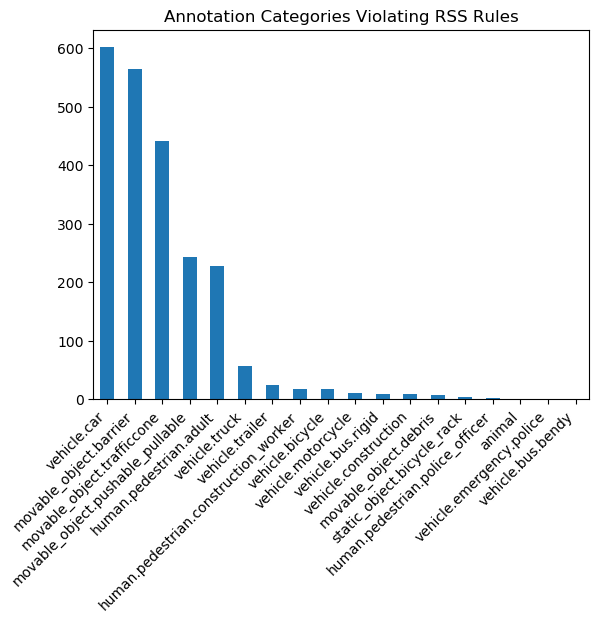

In [108]:
unsafe_anns = full_df.loc[full_df['Safe Overall']=='Not Safe']
unsafe_anns['Annotation Category'].value_counts().plot(kind='bar')
plt.xticks(rotation = 45, ha = 'right')
plt.title('Annotation Categories Violating RSS Rules')

unsafe_anns['Annotation Category'].value_counts()

In [35]:
def safety_score(df):
    
    scoring = df['Overall Safety Percentage']/100
    #print(type(scoring))
    df['Scoring'] = scoring
    
    df.loc[df['Acceleration($m/s^2$)'] > 4.83, 'Scoring'] = scoring * 4.83/(df['Acceleration($m/s^2$)']-4.83)
    df.loc[df['Acceleration($m/s^2$)'] < -4.83, 'Scoring'] = scoring* 4.83/(abs(df['Acceleration($m/s^2$)'])-4.83)

    df['Description']=df['Description'].apply(str.lower)
    df.loc[df['Description'].str.contains('night'), 'Scoring'] = scoring * 0.9
    df.loc[df['Description'].str.contains('rain'), 'Scoring'] = scoring * 0.9
    df.loc[df['Description'].str.contains('high speed'), 'Scoring'] = scoring * 0.9
    df.loc[df['Description'].str.contains('merging'), 'Scoring'] = scoring * 0.9
    df.loc[df['Description'].str.contains('intersection'), 'Scoring'] = scoring * 0.9
    df.loc[df['Description'].str.contains('busy'), 'Scoring'] = scoring * 0.9
    df.loc[df['Description'].str.contains('overtaking'), 'Scoring'] = scoring * 0.9
    
    return df

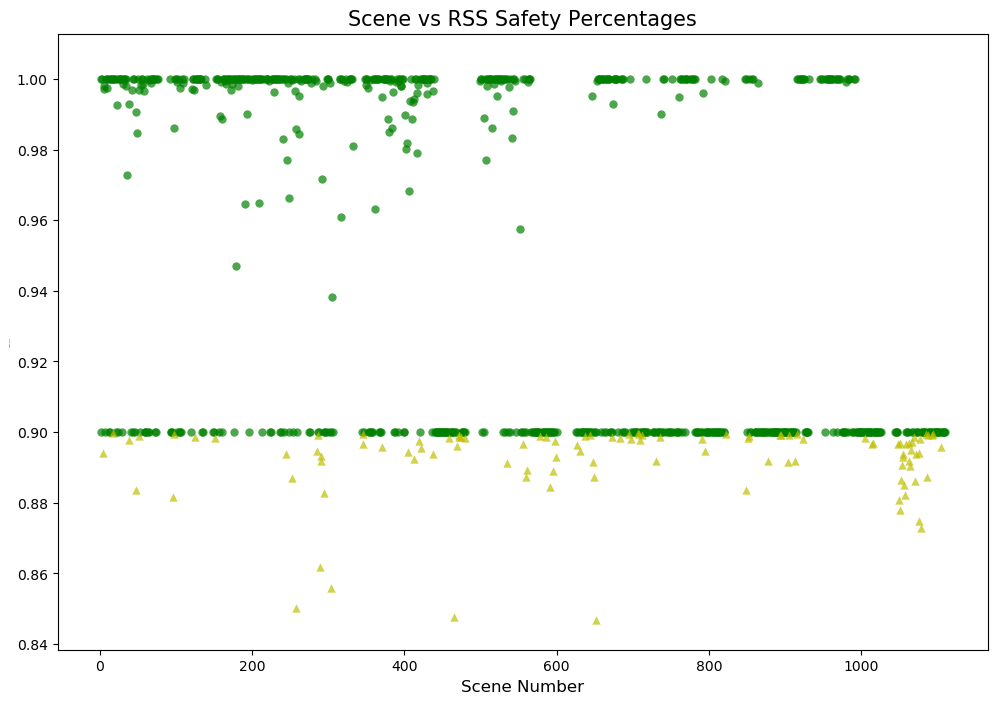

In [36]:
safety = safety_score(percentages_df)
g = safety[safety['Scoring'] >= 0.9]
y = safety[(safety['Scoring'] < 0.9) & (safety['Scoring']>= 0.6)]
o = safety[(safety['Scoring'] < 0.6) & (safety['Scoring']>= 0.4)]
r = safety[safety['Scoring'] < 0.4]
g
# safety.loc[safety['Scoring'] >= 0.9, 'C'] = 'g'
# safety.loc[(safety['Scoring'] < 0.9) & (safety['Scoring']>= 0.6), 'C'] = 'y'
# safety.loc[(safety['Scoring'] < 0.6) & (safety['Scoring']>= 0.4), 'C'] = 'o'
# safety.loc[safety['Scoring'] < 0.4, 'C'] = 'r'
pd.options.display.float_format = '${:,.1f}'.format
fig, ax = plt.subplots(figsize = (12, 8))
# colors = {'g':'#4daf4a', 'y':'#dede00', 'o':'#ff7f00', 'r':'#e41a1c'}
names_green = g['Scene Names'].str.split(pat = '-', expand = True)
names_green = names_green[1]
names_green = names_green.astype(float)
names_yellow = y['Scene Names'].str.split(pat = '-', expand = True)
names_yellow = names_yellow[1]
names_yellow = names_yellow.astype(float)
# names_orange = o['Scene Names'].str.split(pat = '-', expand = True)
# names_orange = names_orange[1]
# names_orange = names_orange.astype(float)
# names_red = r['Scene Names'].str.split(pat = '-', expand = True)
# names_red = names_red[1]
# names_red = names_red.astype(float)
plt.scatter(names_green, g['Scoring'], c='g', linewidth=0, alpha=0.7)
plt.scatter(names_yellow, y['Scoring'], c='y', linewidth=0, alpha=0.7, marker = '^')
plt.title("Scene vs RSS Safety Percentages", fontsize= 15)
plt.xlabel("Scene Number", fontsize= 12)
plt.ylabel("Safety Score", fontsize= 1)

plt.show()

In [107]:
lowest_five = safety.nsmallest(5,"Scoring") 
# lowest_five.loc[231, 'Description']
largest_five = safety.nlargest(6,"Scoring") 
largest_five.loc[12, 'Description']
largest_five

,Scene Names,Description,Vehicle Number,Location,Acceleration($m/s^2$),Longitudinal Safety Percentage,Lateral Safety Percentage,Overall Safety Percentage,Scoring
0,scene-0001,"construction, maneuver between several trucks",n015,singapore-onenorth,$0.1,$93.8,$96.7,$100.0,$1.0
2,scene-0003,"parking lot, barrier, exit parking lot",n015,singapore-onenorth,$0.1,$97.6,$99.0,$100.0,$1.0
7,scene-0008,"several moving pedestrians, parked cards and m...",n015,singapore-onenorth,$-0.0,$91.6,$97.5,$100.0,$1.0
8,scene-0009,"peds crossing, parked cars, garbage, peds waiting",n015,singapore-onenorth,$0.0,$72.2,$99.4,$100.0,$1.0
10,scene-0011,"turn left, pass trucks on both sides, construc...",n015,singapore-onenorth,$0.1,$95.9,$96.3,$100.0,$1.0
12,scene-0013,"follow bus, parked cars, trash cans, parked bi...",n015,singapore-onenorth,$0.1,$91.9,$99.6,$100.0,$1.0


# Lowest scores

scene-0651 score - 0.8469124423963134 - accel of 0.3 - RSS percentage 94.1 - Description is 'rain, start at intersection, parked cars, wait to turn, trash can, turn left', time - [18-09-18 18:50:41]

scene-0465 score - 0.847711267605634 - accel of 0.2 - RSS perecntage 94.2 - Description is 'rain, start at intersection, wet ground, traffic cone loaded on a truck, car overtaking us', time - [18-09-18 16:58:47]

scene-0257 score - 0.8502169197396963 - accel of 0.0 - RSS perecntage 94.5 - Description is 'wait at intersection, heavy trucks, bicyclist', time - [18-08-06 19:09:57]

scene-0304 score - 0.8558648111332009 - accel of 0.3 - RSS perecntage 95.1 - Description is 'cross intersection, turning truck, parked truck', time - [18-08-31 15:31:48]

scene-0289 score - 0.8617886178861789 - accel of -0.3 - RSS perecntage 95.8 - Description is 'dense traffic, car overtaking us, digital traffic sign, parked cars, bike rack', time - [18-08-31 15:23:46]

All of these scenes are in boston. Each had a safe acceleration/deceleration. Each had scenes violating RSS rules

# Highest scores

scene-0001 score - 1 - accel of 0.1 - RSS percentage 100 - Description is 'construction, maneuver between several trucks' - Time - [18-07-18 03:12:10]

scene-0003 score - 1 - accel of 0.1 - RSS perecntage 100 - Description is 'parking lot, barrier, exit parking lot', time - [18-08-02 09:17:50]

scene-0008 score - 1 - accel of 0.0 - RSS perecntage 100 - Description is 'several moving pedestrians, parked cards and motorcycle', time - [18-07-18 03:24:37]

scene-0009 score - 1 - accel of 0.0 - RSS perecntage 100 - Description is 'peds crossing, parked cars, garbage, peds waiting', time - [18-07-18 03:24:57] 

scene-0013 score - 1 - accel of 0.1 - RSS perecntage 100 - Description is 'follow bus, parked cars, trash cans, parked bicycles, nature', time - [18-07-18 03:42:20]

All of these scenes are in singapore north.

<b>Reminder</b>: The vehicle number is going to be the same for each location as they use the same car in each different city/area. 

Add <b>acceleration</b> to the dataframe with a safety percentage also. Here is an example of what is considered safe acceleration/decceleration:

Many safety experts use 15 ft/sec2 (0.47 g's) as the maximum deceleration that is safe for the average driver to maintain control, good to excellent tires, dry surface. A reasonably skilled driver can stop at 20 ft/sec2 (0.62 g's). Most production street vehicles have a maximum braking around 0.8 g's.

Another thing to add is <b>visibility</b> percentage throughout a scene. Get all the percentages and average them out. 

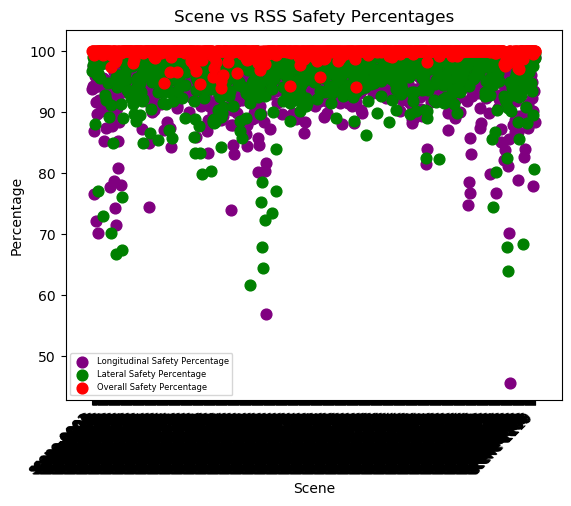

In [30]:
long = plt.scatter(percentages_df['Scene Names'], percentages_df['Longitudinal Safety Percentage'], s=60, c='purple')
lat = plt.scatter(percentages_df['Scene Names'], percentages_df['Lateral Safety Percentage'], s=60, c='green')
overall = plt.scatter(percentages_df['Scene Names'], percentages_df['Overall Safety Percentage'], s=60, c='red')

plt.legend((long, lat, overall),
           ('Longitudinal Safety Percentage', 'Lateral Safety Percentage', 'Overall Safety Percentage'),
           scatterpoints=1,
           loc='best',
           fontsize=6)

plt.xticks(rotation=45, ha='right')
plt.title("Scene vs RSS Safety Percentages")
plt.xlabel("Scene")
plt.ylabel("Percentage")

plt.show()

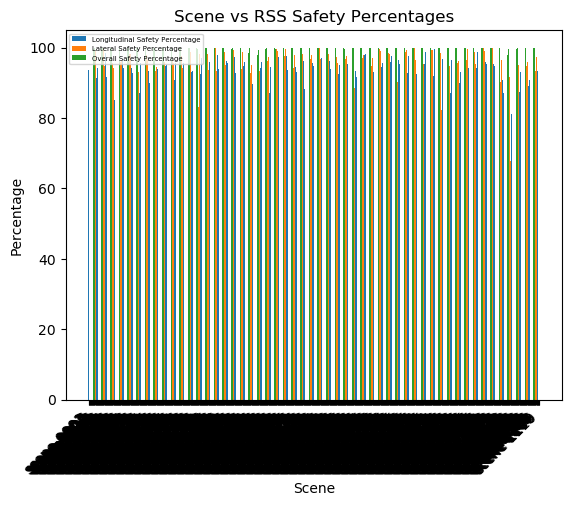

In [31]:
# create data
# create data
x = np.arange(len(percentages_df['Scene Names']))
width = 0.2
  
# plot data in grouped manner of bar type

long = plt.bar(x-width, percentages_df['Longitudinal Safety Percentage'], width)
lat = plt.bar(x, percentages_df['Lateral Safety Percentage'], width)
overall = plt.bar(x+width, percentages_df['Overall Safety Percentage'], width)
plt.xticks(x, percentages_df['Scene Names'])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Scene")
plt.ylabel("Percentage")
plt.title("Scene vs RSS Safety Percentages")
plt.legend((long, lat, overall),
           ('Longitudinal Safety Percentage', 'Lateral Safety Percentage', 'Overall Safety Percentage'),
           loc='best',
           fontsize=5)

plt.show()

Overall, we can see that longtudinal safety is lower than lateral safety as a general trend. However, most of the scenes have a generally high safety score in terms of RSS safety. 